I initially found natural language models tricky to get started with especially once I moved on from starter tasks like sentiment analysis. I wanted to share this notebook to show how some common and slightly more complex language tasks could be approached. In this notebook I have used Googles question answering dataset to show how to match questions to answers and how to extract shorter answers from longer ones.

In [ ]:
import json
from tqdm.notebook import tqdm

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, SpatialDropout1D, Dense, Dropout, Input, concatenate, Conv1D, Activation, Flatten

from nltk.corpus import stopwords
import re

To make it easier to experiement with hyper-parameter tweaking experiments I have added them to this notebook as globals here.

In [ ]:
# data to load
NUM_OF_TRAIN_QUESTIONS = 1000
NUM_OF_VAL_QUESTIONS = 1050
SAMPLE_RATE = 15
TRAIN_PATH = '../input/tensorflow2-question-answering/simplified-nq-train.jsonl'

# TOKENIZATION
FILTERS = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
LOWER_CASE = True
MAX_LEN = 300

# long answer model parameters
EPOCHS = 40
BATCH_SIZE = 64
EMBED_SIZE = 100
CLASS_WEIGHTS = {0: 0.5, 1: 5.}

# short answer model parameters
SHORT_EPOCHS = 80
SHORT_BATCH_SIZE = 32
SHORT_EMBED_SIZE = 200

# Matching questions to long answers

The first task I'll approach in this notebook is how to find answers that are relevant to the question asked. So if someone typed the following question into Google search:

> "how i.met your mother who is the mother"

How would we find the paragraph in wikipedia that contains the answer? For example, if we had the two following potential answers from a wikipedia page how would a machine recognise that the first paragraph is more likely to contain the answer than the second one:

> "Tracy McConnell, better known as 'The Mother', is the title character from the CBS television sitcom How I Met Your Mother. The show, narrated by Future Ted, tells the story of how Ted Mosby met The Mother. Tracy McConnell appears in 8 episodes from 'Lucky Penny' to 'The Time Travelers' as an unseen character; she was first seen fully in 'Something New' and was promoted to a main character in season 9. The Mother is played by Cristin Milioti."

> "In 'Bass Player Wanted', the Mother picks up a hitchhiking Marshall, carrying his son Marvin, on her way to Farhampton Inn. On their way, it is revealed that the Mother is a bass player in the band, that is scheduled to play at the wedding reception. But the band's leader, Darren, forced her to quit. The Mother ultimately decides to confront Darren and retake the band. She ends up alone at the bar, and while practicing a speech to give Darren, Darren walks up to her furious the groom's best man punched him for no reason. Amused by this, the Mother laughs, and Darren quits the band in anger."

Before I get into how to model this I will do the usual pre-processing to get the data ready.

### Load data

The data for this task comes in a rather complex form. The raw data is in a json file with each line of json containing the following:

- **question_text:** A string representing a question asked on Google.
- **document_text:** A string containing the html of the wikipedia page relevant to the question.
- **annotations/long_answer:** A json object containing the start and end index of the correct answer substring (substring of the document_text) 
- **annotations/short_answers:** An array of the possible short answers. Each short answer is represented as the start and end index of the substring that is within document_text).
- **long_answer_candidates:** An array of the possible long answers to the questions. These are basically the paragraphs within the wikipedia page.

I've got a cell of code hidden below that reads a number of rows from the file (specified in the hyper-parameters at the top of this notebook) and puts them into a pandas dataframe. The code is a little long so I have hidden the cell so you can just see the dataframe that I will be working with for the rest of the task.

In [ ]:
def get_line_of_data(file):
    line = file.readline()
    line = json.loads(line)
    
    return line


def get_question_and_document(line):
    question = line['question_text']
    text = line['document_text'].split(' ')
    annotations = line['annotations'][0]
    
    return question, text, annotations
                
                
def get_long_candidate(i, annotations, candidate):
    # check if this candidate is the correct answer
    if i == annotations['long_answer']['candidate_index']:
        label = True
    else:
        label = False

    # get place where long answer starts and ends in the document text
    long_start = candidate['start_token']
    long_end = candidate['end_token']
    
    return label, long_start, long_end


def form_data_row(question, label, text, long_start, long_end):
    row = {
        'question': question,
        'long_answer': ' '.join(text[long_start:long_end]),
        'is_long_answer': label,
    }
    
    return row


def load_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            line = get_line_of_data(file)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True or (i % SAMPLE_RATE == 0):
                    rows.append(
                        form_data_row(question, label, text, long_start, long_end)
                    )
        
    return pd.DataFrame(rows)

In [ ]:
train_df = load_data(TRAIN_PATH, 0, NUM_OF_TRAIN_QUESTIONS)
val_df = load_data(TRAIN_PATH, NUM_OF_TRAIN_QUESTIONS, NUM_OF_VAL_QUESTIONS)

In [ ]:
train_df.head(5)

So this gives me a dataset with two features (question and long_answer) and a binary label (is_long_answer) to predict. This simplifies the challenge into a binary classification task where the model is given a question and a possible answer and returns a probability telling us whether this is the right answer or not.

### Clean and tokenize the text

With the raw data loaded I'll clean up the data to make it easier for the model to train on. There are so many things that can be done here to improve a model. To keep this notebook short I have only removed html tags and stopwords (e.g. "a", "the" and "are"). There are however many more that I could have used to improve this model which can be found in notebooks like this [one](https://www.kaggle.com/raenish/cheatsheet-text-helper-functions).

In [ ]:
def remove_stopwords(sentence):
    words = sentence.split()
    words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)


def remove_html(sentence):
    html = re.compile(r'<.*?>')
    return html.sub(r'', sentence)


def clean_df(df):
    df['long_answer'] = df['long_answer'].apply(lambda x : remove_stopwords(x))
    df['long_answer'] = df['long_answer'].apply(lambda x : remove_html(x))

    df['question'] = df['question'].apply(lambda x : remove_stopwords(x))
    df['question'] = df['question'].apply(lambda x : remove_html(x))
    
    return df

In [ ]:
train_df = clean_df(train_df)
val_df = clean_df(val_df)

In [ ]:
train_df.head(5)

Now that the data is clean it can be converted to tokens. This assigns a numeric index to each unique word in the dataset so that an array of integers (representing a sentence of words) can be fed into the model instead of a string. I've included an example below of how a sentence may look like after tokenisation.

> ['how', 'i', 'met', 'your', 'mother', 'who', 'is', 'the', 'mother']

> [2018, 44, 1275, 932, 312, 3293, 1164, 1, 312]

It's worth noting that I also pad sentences so that they are all the same length (which I set to an arbitary 300 words). If a sentence is less than this maximum length they get padded with 0 tokens to get them to 300 words. The model needs the sentences to be the same length but is also taught to ignore the 0 tokens. This is actually a good hyper-parameter to tweak when trying to improve the model.

I'll use the words in loaded questions and answers then to define a tensorflow keras tokenizer. 

In [ ]:
def define_tokenizer(df_series):
    sentences = pd.concat(df_series)
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters=FILTERS, 
        lower=LOWER_CASE
    )
    tokenizer.fit_on_texts(sentences)
    
    return tokenizer

    
def encode(sentences, tokenizer):
    encoded_sentences = tokenizer.texts_to_sequences(sentences)
    
    encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(
        encoded_sentences, 
        padding='post',
        maxlen=MAX_LEN
    )
    
    return encoded_sentences

In [ ]:
tokenizer = define_tokenizer([
    train_df.long_answer, 
    train_df.question,
    val_df.long_answer, 
    val_df.question
])

In [ ]:
tokenizer.word_index['tracy']

With the tokenizer defined I can encode the loaded questions and answers. It is easier to input the sentences into the model as numpy arrays so I have outputted the encoded sentences as numpy arrays of shape (m, 300) where m is the number of sentences in the array and 300 represents the maximum length of all the sentences.

In [ ]:
train_long_answers = encode(train_df['long_answer'].values, tokenizer)
train_questions = encode(train_df['question'].values, tokenizer)

val_long_answers = encode(val_df['long_answer'].values, tokenizer)
val_questions = encode(val_df['question'].values, tokenizer)

Let's take a look at what a sentence that is ready to be inputted into the model looks like.

In [ ]:
train_long_answers[0]

The final piece of pre-processing to be done is to create an array of binary labels for the model. The labels were boolean values in the model so they have simply been converted to 0-1 integers as the model prefers them that way.

In [ ]:
train_labels = train_df.is_long_answer.astype(int).values
val_labels = val_df.is_long_answer.astype(int).values

In [ ]:
train_labels

### Import GloVe embedding

With the data loaded and pre-processed I can now define the model. Natural language models rely on an embedding layer to provide meaning to the words in a sentence. I won't go into all the detail here but I like to think about embeddings is as a grid of the words the model understands alongside different meanings:

|             | tracy | excited | mother |
|-------------|-------|---------|--------|
| male/female | 0.8   | 0.5     | 0.95   |
| happy/sad   | 0.5   | 0.9     | 0.6    |

In the above example you can see some sample words in the header with some meanings in the index column. The numbers represent how far that word is one meaning or another. So the word 'mother' for example is a higher number in the first meaning category telling the model that it is more female than masculine while its neutral number in the second category tells the model that it doesn't hold much in the way of happy or sad sentiment. Of course those meaning categories are black box categories in the real embeddings and the human eye would never be able to understand what they really mean. However it is these numbers that help the model understand words as we do.

It usually takes a very long time to train a good embedding. As the meaning of words rarely change from one document to another (assuming they are in the same language) it is a good idea to load a pre-trained embedding. I'll use the popular GloVe embeddings for this challenge. GloVe can be loaded with either 50, 100 or 200 dimensions (what I referred to as menaing categories just above). More dimensions tend to mean better accuracy but also longer training times. I have opted for 100 dimensions here.

In [ ]:
embedding_dict = {}

with open('../input/glove-global-vectors-for-word-representation/glove.6B.' + str(EMBED_SIZE) + 'd.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
        
f.close()

In [ ]:
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, EMBED_SIZE))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

### Define model

For this challenge I'll define one of the simpler models that can be used. For bleeding edge results BERT is probably the best model to use. However this works for now and is something that helped me understand the fundamentals of how these types of models work.

The model works by inserting one question and one potential answer as a pair. The model then outputs a probability telling us the what extent the potential answer is in fact, the correct answer for this question. We could run this model against all potential answers for a question and use the highest probability  to determine which answer is correct.

With this in mind, the model I'll use has three parts to it:

- **Question encoding:** This part of the model encodes the question. That is it uses the embeddings discussed earlier and a bidirectional LSTM layer to determine the meaning of the sentence. This outputs an encoded array representing the sentence in a way that the model can understand its meaning.
- **Answer encoding:** This is the same the question encoding part except it does this for a potential answer.
- **Classification:** This takes the sentence encodings from the two encoding parts of the model, compares them using dense layers and outputs a probability regarding how close the potential answer is to the true answer to this question.

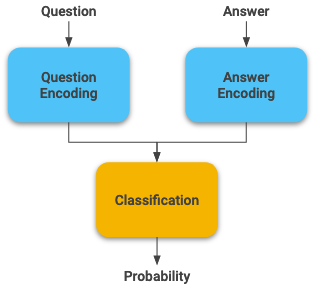

In [ ]:
embedding = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    EMBED_SIZE,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

In [ ]:
# question encoding
question_input = Input(shape=(None,))
question_x = embedding(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)
question_x = GlobalMaxPooling1D()(question_x)

# answer encoding
answer_input = Input(shape=(None,))
answer_x = embedding(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)
answer_x = GlobalMaxPooling1D()(answer_x)

# classification
combined_x = concatenate([question_x, answer_x])
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
combined_x = Dense(300, activation='relu')(combined_x)
combined_x = Dropout(0.5)(combined_x)
output = Dense(1, activation='sigmoid')(combined_x)

# combine model parts into one
model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=output)

While this model has quite a few moing parts, at its heart it is just a binary classification model. This means I can make use of the easy and well tested loss function that is binary cross-entropy. I'll also use adam to optimise the model.

In [ ]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['BinaryAccuracy', 'Recall', 'Precision']
)

I'll also define a few callbacks. The first helps the model to avoid plateauing as it approaches zero loss. I've also added early stopping in case the model reaches the optimum before it has finished its final epoch.

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

Finally the model can begin training. One extra hyper-parameter to mention here is the class weights. This dataset contains far more wrong answers (label 0) than correct answers (label 1). While I want the model to know when it sees a wrong answer, I'd like it to focus more on the correct answers that it sees. As such I have weighted the correct answers far more heavily than the wrong answers.

On GPU 40 epochs should take around 8 minutes. On CPU it will take about an hour and a half.

In [ ]:
history = model.fit(
    x = [train_long_answers, train_questions], 
    y = train_labels,
    validation_data = (
        [val_long_answers, val_questions], 
        val_labels
    ),
    epochs = EPOCHS,
    callbacks = callbacks,
    class_weight = CLASS_WEIGHTS,
    batch_size = BATCH_SIZE,
    shuffle = True
)

## Evaluate

To evaluate the model there are a lot of the usual quantitative methods. A good start is the loss curve across both the training and validation datasets. If they are both trending down the model is learning something.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

The same can be done with the other metrics, accuracy, recall and precision. This time I'm hoping the curves trend upwards.

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['binary_accuracy'])

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_binary_accuracy'])

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['recall'])

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_recall'])

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['precision'])

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_precision'])

I'll also print out the number of epochs the model trained for to see if early stopping took place.

In [ ]:
print('Epochs: {0}'.format(
    len(history.history['loss'])
))

The final metric I'll use is F1 score. This is a combination of precision and recall and the metric the competition (now closed) used to measure the quality of models. It's thus a good single metric that encompasses the quality of the model.

In [ ]:
recall = history.history['recall'][-1]
precision = history.history['precision'][-1]

print('Train F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

In [ ]:
recall = history.history['val_recall'][-1]
precision = history.history['val_precision'][-1]

print('Validation F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

Quantitative methods are a great way to see the whole models quality in one number. However I always find it invaluable to look at some of the results the model produces. This helps me validate the metrics and see exactly what users would see if this model were to be deployed to an application. To this end I have defined a function that takes a question, the right answer (positive) and a wrong answer (negative) and returns the probability for each of the two answers. I'm expecting to see a high probability for the right answer and low probability for the wrong answer. The greater the difference between the numbers, the better.

In [ ]:
def test_question(question, positive, negative):
    sentences = [question, positive, negative]
    
    for i in range(3):
        sentences[i] = remove_stopwords(sentences[i])
        sentences[i] = remove_html(sentences[i])
    
    sentences = encode(sentences, tokenizer)
    
    predictions = model.predict(
        [np.expand_dims(sentences[1], axis=0), np.expand_dims(sentences[0], axis=0)]
    )

    print('Positive: {0:.2f}'.format(predictions[0][0]))

    predictions = model.predict(
        [np.expand_dims(sentences[2], axis=0), np.expand_dims(sentences[0], axis=0)]
    )

    print('Negative: {0:.2f}'.format(predictions[0][0]))

Here's a sample question with two answers from the training dataset. Let's see how the model does with them.

In [ ]:
question = 'which is the most common use of opt-in e-mail marketing'

positive = "<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>"

negative = '<P> Email marketing has evolved rapidly alongside the technological growth of the 21st century . Prior to this growth , when emails were novelties to the majority of customers , email marketing was not as effective . In 1978 , Gary Thuerk of Digital Equipment Corporation ( DEC ) sent out the first mass email to approximately 400 potential clients via the Advanced Research Projects Agency Network ( ARPANET ) . This email resulted in $13 million worth of sales in DEC products , and highlighted the potential of marketing through mass emails . However , as email marketing developed as an effective means of direct communication , users began blocking out content from emails with filters and blocking programs . In order to effectively communicate a message through email , marketers had to develop a way of pushing content through to the end user , without being cut out by automatic filters and spam removing software . This resulted in the birth of triggered marketing emails , which are sent to specific users based on their tracked online browsing patterns . </P>'

In [ ]:
test_question(question, positive, negative)

In [ ]:
question = 'how i.met your mother who is the mother'

positive = "<P> Tracy McConnell , better known as `` The Mother '' , is the title character from the CBS television sitcom How I Met Your Mother . The show , narrated by Future Ted , tells the story of how Ted Mosby met The Mother . Tracy McConnell appears in 8 episodes from `` Lucky Penny '' to `` The Time Travelers '' as an unseen character ; she was first seen fully in `` Something New '' and was promoted to a main character in season 9 . The Mother is played by Cristin Milioti . </P>"

negative = "<P> In `` Bass Player Wanted '' , the Mother picks up a hitchhiking Marshall , carrying his son Marvin , on her way to Farhampton Inn . On their way , it is revealed that the Mother is a bass player in the band , that is scheduled to play at the wedding reception . But the band 's leader , Darren , forced her to quit . The Mother ultimately decides to confront Darren and retake the band . She ends up alone at the bar , and while practicing a speech to give Darren , Darren walks up to her furious the groom 's best man punched him for `` no reason . '' Amused by this , the Mother laughs , and Darren quits the band in anger . </P>"

In [ ]:
test_question(question, positive, negative)

I've always been impressed when I ask Google the same question but slightly differently and it still understands it as the same question. Let's see if this model can do this.

In [ ]:
question = 'how i met your mother who is the mother'
test_question(question, positive, negative)

In [ ]:
question = 'who is tracy mcconnell'
test_question(question, positive, negative)

Not bad. Even when the question is phrased in a very different way i.e. ask who Tracy is rather than who the mother is, the model still knows I am asking about the mother in "How I met your mother" and returns the right answer.

# Text extraction

With the correct long answer matched to a question, the next challenge is to extract the short answer from a long answer. So if the correct answer is a paragraph about who the mother in "How I met your mother" is:

> "Tracy McConnell, better known as 'The Mother', is the title character from the CBS television sitcom How I Met Your Mother. The show, narrated by Future Ted, tells the story of how Ted Mosby met The Mother. Tracy McConnell appears in 8 episodes from 'Lucky Penny' to 'The Time Travelers' as an unseen character; she was first seen fully in 'Something New' and was promoted to a main character in season 9. The Mother is played by Cristin Milioti."

The correct short answer would be the mothers name:

> "Tracy McConnell"

The approach to this challenge isn't too different from the question, answer matching model above. The pre-processing is much the same. So first I'll load the dataset filtering out the wrong long answers and extracting the start and end index of the short answer within the long answer. The start and end index are the indexes of the words in the long answer that make up the short answer. So if we use the same example answer above, the start and end index would 0 and 1 as the short answer begins on the first word of the long answer and ends of the second word.

I've hidden the code for transforming the json file into a pandas dataset again.

In [ ]:
def get_short_answer(annotations, long_start, long_end):
    if len(annotations['short_answers']) > 0:
        short_start = annotations['short_answers'][0]['start_token']
        short_end = annotations['short_answers'][0]['end_token']
        
        short_start = short_start - long_start
        short_end = short_end - long_start
        
        return short_start, short_end
    else:
        return 0, 0
    

def form_short_data_row(question, text, long_start, long_end, short_start, short_end):
    long_answer = ' '.join(text[long_start:long_end])
    short_answer = ' '.join(long_answer.split(' ')[short_start:short_end])
    
    row = {
        'question': question,
        'long_answer': long_answer,
        'short_answer': short_answer,
        'short_start': short_start,
        'short_end': short_end
    }
    
    return row


def load_short_data(file_path, questions_start, questions_end):
    rows = []
    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            line = get_line_of_data(file)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)

                if label == True:
                    short_start, short_end = get_short_answer(annotations, long_start, long_end)
                    
                    rows.append(
                        form_short_data_row(question, text, long_start, long_end, short_start, short_end)
                    )
        
    return pd.DataFrame(rows)

In [ ]:
train_short_df = load_short_data(TRAIN_PATH, 0, NUM_OF_TRAIN_QUESTIONS)
val_short_df = load_short_data(TRAIN_PATH, NUM_OF_TRAIN_QUESTIONS, NUM_OF_VAL_QUESTIONS)

In [ ]:
train_short_df.head()

Usually I would clean the text here but it can get a little confusing when trying to extract text if sentences have parts removed from them. As such they have been maintained. However I have kept the tokeniser used in the first challenge of this notebook which I use here to encode the dataset.

In [ ]:
train_long_answers = encode(train_short_df['long_answer'].values, tokenizer)
train_questions = encode(train_short_df['question'].values, tokenizer)

val_long_answers = encode(val_short_df['long_answer'].values, tokenizer)
val_questions = encode(val_short_df['question'].values, tokenizer)

The labels look a little different this time. The model will be outputting two arrays (for for the start index and another for the end index) 300 elements in length (to represent the 300 words in a padded sentence). All but one of the elements in the arrays will be a zero value. The one value of the arrays that is a value of one represents the  models predicted start or end of a short answer.

In [ ]:
def form_short_labels(df, sentence_length):
    start_labels = np.zeros((len(df), sentence_length))
    end_labels = np.zeros((len(df), sentence_length))

    for i in range(len(df)):
        start = df.loc[i].short_start
        end = df.loc[i].short_end

        if start < 300 and end < 300:
            start_labels[i, start] = 1
            end_labels[i, end] = 1
        else:
            continue
    
    return start_labels, end_labels


train_start_labels, train_end_labels = form_short_labels(train_short_df, MAX_LEN)
val_start_labels, val_end_labels = form_short_labels(val_short_df, MAX_LEN)

Let's see an example. Here the correct short answer is "a newsletter sent to an advertising firm's customers". If you are counting the words in the sentence to see if they match the label, be sure to include the html tag in the count.

In [ ]:
print(train_short_df.loc[0].long_answer)
print('Start index: {0}'.format(train_start_labels[0]))
print('End index: {0}'.format(train_end_labels[0]))

With the data ready to go I'll begin defining the model. The below code imports the glove embeddings again and the code is much the same as last time I used it in this notebook. However this model requires more dimensions (200) to be effective meaning I couldn't just re-use the embeddings from the question, answer model.

In [ ]:
# load from file
embedding_dict = {}

with open('../input/glove-global-vectors-for-word-representation/glove.6B.' + str(SHORT_EMBED_SIZE) + 'd.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
        
f.close()

# write to matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, SHORT_EMBED_SIZE))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec
        
# load as tensorflow embedding
embedding = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    SHORT_EMBED_SIZE,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = False
)

The model itself looks similar to last time. There are three parts where the first two encode the question and the answer. They feed into the classification part of the model that then predicts the start and the end indexes of the short answer. The two encoding parts are much the same as the encoding parts in the last model. Only the classification part has changed which uses convolutional layers instead of dense ones and outputs two arrays instead of one.

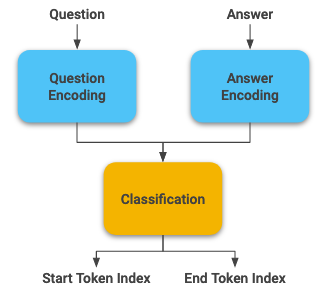

In [ ]:
# encode question
question_input = Input(shape=(None,))
question_x = embedding(question_input)
question_x = SpatialDropout1D(0.2)(question_x)
question_x = Bidirectional(LSTM(200, return_sequences=True))(question_x)
question_x = Bidirectional(LSTM(100, return_sequences=True))(question_x)

# encode answer
answer_input = Input(shape=(None,))
answer_x = embedding(answer_input)
answer_x = SpatialDropout1D(0.2)(answer_x)
answer_x = Bidirectional(LSTM(250, return_sequences=True))(answer_x)
answer_x = Bidirectional(LSTM(150, return_sequences=True))(answer_x)

# merge the encodings
combined_x = concatenate([question_x, answer_x])

# predict start index
start_x = Dropout(0.1)(combined_x) 
start_x = Conv1D(1,1)(start_x)
start_x = Flatten()(start_x)
start_x = Activation('softmax', name='start_token_out')(start_x)

# predict end index
end_x = Dropout(0.1)(combined_x) 
end_x = Conv1D(1,1)(end_x)
end_x = Flatten()(end_x)
end_x = Activation('softmax', name='end_token_out')(end_x)

# merge the parts into one model
short_model = tf.keras.models.Model(inputs=[answer_input, question_input], outputs=[start_x, end_x])

The model will be optimised with adam and use categorical cross entropy as a loss function. Like last time, accuracy, recall and precision will be used to measure the models quality.

In [ ]:
short_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['categorical_accuracy', 'Recall', 'Precision']
)

I've increased the patience of the reduce learning plateau call

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

And once again, set off the training.

In [ ]:
history = short_model.fit(
    x = [train_long_answers, train_questions], 
    y = [train_start_labels, train_end_labels],
    validation_data = (
        [val_long_answers, val_questions], 
        [val_start_labels, val_end_labels]
    ),
    epochs = SHORT_EPOCHS,
    callbacks = callbacks,
    batch_size = SHORT_BATCH_SIZE,
    shuffle = True
)

### Evaluate

As this model has two outputs there are more metrics to display this time. The only one that is the same is the loss for the model.

In [ ]:
print('Epoch: {0}'.format(len(history.history['loss'])))
print('Loss: {0}'.format(history.history['loss'][-1]))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

This model has accuracy, recall and precision metrics for both the start and end index outputs. This is further split by training and validation. Here are the metrics for the start token output of the model.

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('Start Token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['start_token_out_categorical_accuracy'])

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_start_token_out_categorical_accuracy'])

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['start_token_out_recall'])

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_start_token_out_recall'])

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['start_token_out_precision'])

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_start_token_out_precision'])

And here are the metrics of the end token output.

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

fig.suptitle('End Token')

ax[0,0].set_title('Training Accuracy')
ax[0,0].plot(history.history['end_token_out_categorical_accuracy'])

ax[0,1].set_title('Validation Accuracy')
ax[0,1].plot(history.history['val_end_token_out_categorical_accuracy'])

ax[1,0].set_title('Training Recall')
ax[1,0].plot(history.history['end_token_out_recall_1'])

ax[1,1].set_title('Validation Recall')
ax[1,1].plot(history.history['val_end_token_out_recall_1'])

ax[2,0].set_title('Training Precision')
ax[2,0].plot(history.history['end_token_out_precision_1'])

ax[2,1].set_title('Validation Precision')
ax[2,1].plot(history.history['val_end_token_out_precision_1'])

Finally here's a list of all the final metrics for this model.

In [ ]:
accuracy = history.history['start_token_out_categorical_accuracy'][-1]
recall = history.history['start_token_out_recall'][-1]
precision = history.history['start_token_out_precision'][-1]


print('Training')
print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

accuracy = history.history['end_token_out_categorical_accuracy'][-1]
recall = history.history['end_token_out_recall_1'][-1]
precision = history.history['end_token_out_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

In [ ]:
accuracy = history.history['val_start_token_out_categorical_accuracy'][-1]
recall = history.history['val_start_token_out_recall'][-1]
precision = history.history['val_start_token_out_precision'][-1]


print('Validation')
print('Start token accuracy: {0}'.format(accuracy))
print('Start token recall: {0}'.format(recall))
print('Start token precision: {0}'.format(precision))
print('Start token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

accuracy = history.history['val_end_token_out_categorical_accuracy'][-1]
recall = history.history['val_end_token_out_recall_1'][-1]
precision = history.history['val_end_token_out_precision_1'][-1]

print('End token accuracy: {0}'.format(accuracy))
print('End token recall: {0}'.format(recall))
print('End token precision: {0}'.format(precision))
print('End token F1 score: {0:.4f}'.format(
    2 * (precision * recall) / (precision + recall)
))

Like last time, let's finsih off with a look at how the model performs on some examples.

In [ ]:
def test_short_answer(question, long_answer):
    sentences = [long_answer, question]
    
    sentences = encode(sentences, tokenizer)
    
    predictions = short_model.predict(
        [np.expand_dims(sentences[0], axis=0), np.expand_dims(sentences[1], axis=0)]
    )
    
    predictions = np.array(predictions)
    
    pred_start = np.argmax(predictions[0,0])
    pred_end = np.argmax(predictions[1,0])
    pred_string = ' '.join(long_answer.split(' ')[pred_start:pred_end])

    return pred_start, pred_end, pred_string

In [ ]:
question = 'which is the most common use of opt-in e-mail marketing'
long_answer = "<P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>"

In [ ]:
start, end, short_answer = test_short_answer(question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

In [ ]:
question = 'how i.met your mother who is the mother'
long_answer = "<P> Tracy McConnell , better known as `` The Mother '' , is the title character from the CBS television sitcom How I Met Your Mother . The show , narrated by Future Ted , tells the story of how Ted Mosby met The Mother . Tracy McConnell appears in 8 episodes from `` Lucky Penny '' to `` The Time Travelers '' as an unseen character ; she was first seen fully in `` Something New '' and was promoted to a main character in season 9 . The Mother is played by Cristin Milioti . </P>"

In [ ]:
start, end, short_answer = test_short_answer(question, long_answer)

print('Start token: ' + str(start))
print('End token: ' + str(end))
print('Answer: ' + short_answer)

# Final thoughts

It took me a few days to work out how these models work but it turns out that it's not difficult to get language models like these working to some extent. If these models were to be made competition ready though I would endeavour to use the BERT model (or an equivalent such as roberta) and apply far more pre-processing to the text before it goes into the model. I would also increase how much data the model is trained on as it is likely to be overfit with so few examples fed into it. In the meantime I hope this helps anyone looking to get started with natural language tasks such as these.